<a href="https://colab.research.google.com/github/ayualfaniyah/model-training-tomato-dataset/blob/main/2_Model_Penyakit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os
local_zip = '/content/drive/MyDrive/Tomatt Belumm Di Proses Balance.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

print("Jumlah Data Train Tiap Kelas")
print('Jumlah gambar bagus    :', len(os.listdir('/content/Penyakit/Bagus')))
print('Jumlah gambar penyakitan  :', len(os.listdir('/content/Penyakit/Penyakitan')))

Jumlah Data Train Tiap Kelas
Jumlah gambar bagus    : 376
Jumlah gambar penyakitan  : 376


In [ ]:
os.mkdir('/tmp/s/')
os.mkdir('/tmp/s/train/')
os.mkdir('/tmp/s/val/')
os.mkdir('/tmp/s/train/Bagus/')
os.mkdir('/tmp/s/val/Bagus/')
os.mkdir('/tmp/s/train/Penyakitan/')
os.mkdir('/tmp/s/val/Penyakitan/')

In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

train_ratio = 0.8

#Pembagian Training dan Validasi

source_00 = '/content/Penyakit/Bagus/'
train_00 = '/tmp/s/train/Bagus/'
val_00 = '/tmp/s/val/Bagus/'
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = '/content/Penyakit/Penyakitan/'
train_01 = '/tmp/s/train/Penyakitan/'
val_01 = '/tmp/s/val/Penyakitan/'
train_val_split(source_01, train_01, val_01, train_ratio)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale = 1./255.,
                  rotation_range = 30,
                  horizontal_flip = True,
                  shear_range = 0.3,
                  fill_mode = 'nearest',
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                rescale = 1./255.,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

In [ ]:
train_dir = '/tmp/s/train/'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 8,
    class_mode = 'categorical'
)

val_dir = '/tmp/s/val/'
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 8,
    class_mode = 'categorical'
)

Found 600 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [ ]:
# callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout, BatchNormalization

In [ ]:
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

# Freeze the pre-trained base model layers
MobileNetV2_base.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Build the model
model = Sequential()

# Add the pre-trained Xception base
model.add(MobileNetV2_base)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.10))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(100, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(30, activation='relu'))

# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 2)                 6

In [ ]:
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
%%time
# # Define the callback function
early_stopping = EarlyStopping(patience=10)

history= model.fit(train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks = [callbacks]
)

Epoch 1/100
75/75 [==============================] - 115s 1s/step - loss: 0.3907 - accuracy: 0.8250 - val_loss: 0.2344 - val_accuracy: 0.9145
Epoch 2/100
75/75 [==============================] - 105s 1s/step - loss: 0.1913 - accuracy: 0.9250 - val_loss: 0.2335 - val_accuracy: 0.8882
Epoch 3/100
75/75 [==============================] - 102s 1s/step - loss: 0.1834 - accuracy: 0.9333 - val_loss: 0.1566 - val_accuracy: 0.9408
Epoch 4/100
75/75 [==============================] - 121s 2s/step - loss: 0.1430 - accuracy: 0.9567 - val_loss: 0.1147 - val_accuracy: 0.9408
Epoch 5/100
75/75 [==============================] - 132s 2s/step - loss: 0.1561 - accuracy: 0.9417 - val_loss: 0.1084 - val_accuracy: 0.9474
Epoch 6/100
75/75 [==============================] - 102s 1s/step - loss: 0.1468 - accuracy: 0.9467 - val_loss: 0.0833 - val_accuracy: 0.9605
Epoch 7/100
75/75 [==============================] - 132s 2s/step - loss: 0.1137 - accuracy: 0.9633 - val_loss: 0.1088 - val_accuracy: 0.9539
Epoch 

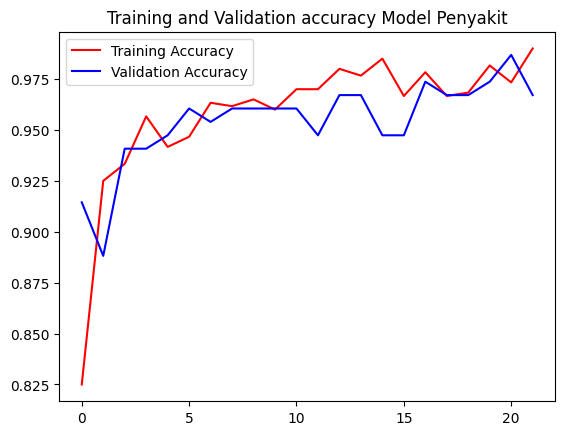

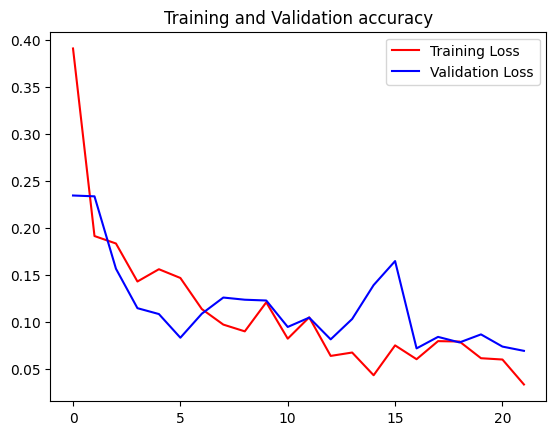

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy ')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy Model Penyakit')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

In [ ]:
model.save('model_Penyakit_mobilenetV2_balance_tuning.h5')
model_saved = tf.keras.models.load_model('model_Penyakit_mobilenetV2_balance_tuning.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
bnn = []
for layer in MobileNetV2_base.layers:
    bnn.append(layer.name)
print(bnn)
print("Panjang Layer adalah {}".format(len(bnn)))

['input_1', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
import numpy as np
import itertools
import tensorflow as tf

img_array = cv2.imread("tomat.jpg")
lapisan = bnn[20] #masukan layer pada variable bnn dimulai dari 0-N Contoh bnn[0](Berarti layer nomer 1)
last_layer = MobileNetV2_base.get_layer(lapisan)
last_output = last_layer.output
input_l = MobileNetV2_base.input
bn = tf.keras.Model(input_l, last_output)
mobnett = Sequential(bn)
resize = cv2.resize(img_array, (224,224))
pred = mobnett.predict(np.expand_dims(resize,0))
row = 5
col = 5
fig, axs = plt.subplots(row, col, figsize=(10,10))

for idx, ax_idx in enumerate(list(itertools.product(range(row), range(col)))):
    axs[ax_idx[0], ax_idx[1]].imshow(pred[0,:,:,idx])

plt.tight_layout()
plt.show()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


Saving IMG_20240208_192641.jpg to IMG_20240208_192641.jpg
1/1 [==============================] - 1s 1s/step
IMG_20240208_192641.jpg
Akurasi Prediksi yang ditampilkan sangat kecil, Coba Gambar yang lain


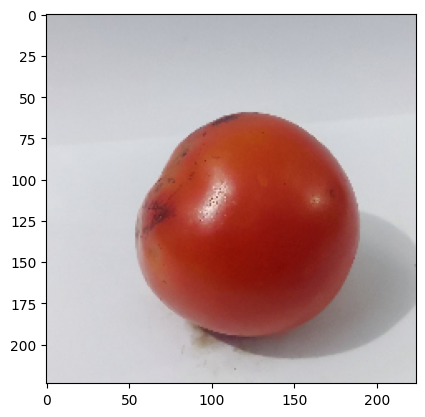

In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir('/tmp/s/train/')

if np.max(classes[0]) == 1.:
    predicted_class = np.argmax(classes[0])
    print('Gambar Berikut Termasuk dalam Ketegori:', class_list[predicted_class])
else:
    print("Akurasi Prediksi yang ditampilkan sangat kecil, Coba Gambar yang lain")

1/1 [==============================] - 0s 47ms/step
[0.00147838]


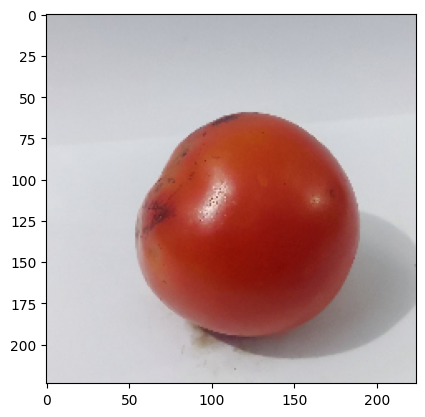

In [ ]:
  img = image.load_img('/content/IMG_20240208_192641.jpg', target_size = (224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model_saved.predict(images, batch_size = 100)
  print(classes[:,0])

In [ ]:
np.max(classes)

0.9985216

In [ ]:
os.listdir('/tmp/s/train/')

['Penyakitan', 'Bagus']